In [1]:
from IPython.core.display import display, HTML

import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import gc

from joblib import Parallel, delayed

from sklearn import preprocessing, model_selection
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt 
import seaborn as sns
import numpy.matlib


path_submissions = '/'

target_name = 'target'
scores_folds = {}

In [2]:
!python --version
!pip -q install ../input/tabnet/pytorch_tabnet-2.0.1-py3-none-any.whl

Python 3.7.10


* ### I just tried different parameters and weights of 2  models. Cross validation with different folds was also attempted, but failed.

In [3]:
# data directory
data_dir = '../input/optiver-realized-volatility-prediction/'

# Function to calculate first WAP
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

# Function to calculate second WAP
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def calc_wap3(df):
    wap = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap4(df):
    wap = (df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

# Function to calculate the log of the return
# Remember that logb(x / y) = logb(x) - logb(y)
def log_return(series):
    return np.log(series).diff()

# Calculate the realized volatility
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

#我加的===================================================================

def RSI(close,n):
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

#========================================================================

# Function to count unique elements of a series
def count_unique(series):
    return len(np.unique(series))

# Function to read our base train and test set
def read_train_test():
    train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
    test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')
#     train = train[:100]
#     test=test[:100]
    # Create a key to merge with book and trade data
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    
    print(f'Our training set has {train.shape[0]} rows')
    return train, test

# Function to preprocess book data (for each stock id)
def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    # Calculate Wap
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    df['wap3'] = calc_wap3(df)
    df['wap4'] = calc_wap4(df)
    # Calculate log returns
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    df['log_return3'] = df.groupby(['time_id'])['wap3'].apply(log_return)
    df['log_return4'] = df.groupby(['time_id'])['wap4'].apply(log_return)
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    # Calculate spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['price_spread2'] = (df['ask_price2'] - df['bid_price2']) / ((df['ask_price2'] + df['bid_price2']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df["bid_ask_spread"] = abs(df['bid_spread'] - df['ask_spread'])
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    # Dict for aggregations
    create_feature_dict = {
        'wap1': [np.sum, np.mean, np.std],
        'wap2': [np.sum, np.mean, np.std],
        'wap3': [np.sum, np.mean, np.std],
        'wap4': [np.sum, np.mean, np.std],
        'log_return1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std],
        'log_return3': [np.sum, realized_volatility, np.mean, np.std],
        'log_return4': [np.sum, realized_volatility, np.mean, np.std],
        'wap_balance': [np.sum, np.mean, np.std],
        'price_spread':[np.sum, np.mean, np.std],
        'price_spread2':[np.sum, np.mean, np.std],
        'bid_spread':[np.sum, np.mean, np.std],
        'ask_spread':[np.sum, np.mean, np.std],
        'total_volume':[np.sum, np.mean, np.std],
        'volume_imbalance':[np.sum, np.mean, np.std],
        "bid_ask_spread":[np.sum, np.mean, np.std],
    }
    create_feature_dict_time = {
        'log_return1': [realized_volatility],
        'log_return2': [realized_volatility],
        'log_return3': [realized_volatility],
        'log_return4': [realized_volatility],
    }
    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)

    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id__100'], axis = 1, inplace = True)
    
    #我加的===================================================================
    df_new_features = df[['time_id']].copy()
    df['mid'] = (df['ask_price1']+ df['bid_price1'])/2
    #STD(price)
    for window in [100,200,300,400,500]:
        df[f'mid_ma_{window}'] = df['mid'].rolling(window=window).mean()
        #|price-MA|
        df[f'price_to_ma_{window}'] = abs(df['mid'] - df[f'mid_ma_{window}'])
        df[f'price_to_ma_{window}'].bfill(inplace=True)
        df_new_features[f'price_to_ma_{window}'] = df.groupby('time_id')[f'price_to_ma_{window}'].transform('mean')
    for n in [30,60,100]:
        df[f'rsi_{n}']=RSI(df['mid'],n=n)
        df[f'rsi_{n}'].bfill(inplace=True)
        df_new_features[f'rsi_{n}'] = df.groupby('time_id')[f'rsi_{n}'].transform('mean')
    df_new_features.drop_duplicates(subset='time_id', keep='first', inplace=True)     
    df_feature = df_feature.merge(df_new_features, how = 'left', left_on = 'time_id_', right_on = 'time_id')
    df_feature.drop(['time_id'], axis = 1, inplace = True)
    #我加的===================================================================
    
    # Create row_id so we can merge
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to preprocess trade data (for each stock id)
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    df['amount']=df['price']*df['size']
    # Dict for aggregations
    create_feature_dict = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum, np.max, np.min],
        'order_count':[np.sum,np.max],
        'amount':[np.sum,np.max,np.min],
    }
    create_feature_dict_time = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.sum],
    }
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    

    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)
    
    def tendency(price, vol):    
        df_diff = np.diff(price)
        val = (df_diff/price[1:])*100
        power = np.sum(val*vol[1:])
        return(power)
    
    lis = []
    for n_time_id in df['time_id'].unique():
        df_id = df[df['time_id'] == n_time_id]        
        tendencyV = tendency(df_id['price'].values, df_id['size'].values)      
        f_max = np.sum(df_id['price'].values > np.mean(df_id['price'].values))
        f_min = np.sum(df_id['price'].values < np.mean(df_id['price'].values))
        df_max =  np.sum(np.diff(df_id['price'].values) > 0)
        df_min =  np.sum(np.diff(df_id['price'].values) < 0)
        # new
        abs_diff = np.median(np.abs( df_id['price'].values - np.mean(df_id['price'].values)))        
        energy = np.mean(df_id['price'].values**2)
        iqr_p = np.percentile(df_id['price'].values,75) - np.percentile(df_id['price'].values,25)
        
        # vol vars
        
        abs_diff_v = np.median(np.abs( df_id['size'].values - np.mean(df_id['size'].values)))        
        energy_v = np.sum(df_id['size'].values**2)
        iqr_p_v = np.percentile(df_id['size'].values,75) - np.percentile(df_id['size'].values,25)
        
        lis.append({'time_id':n_time_id,'tendency':tendencyV,'f_max':f_max,'f_min':f_min,'df_max':df_max,'df_min':df_min,
                   'abs_diff':abs_diff,'energy':energy,'iqr_p':iqr_p,'abs_diff_v':abs_diff_v,'energy_v':energy_v,'iqr_p_v':iqr_p_v})
    
    df_lr = pd.DataFrame(lis)
        
   
    df_feature = df_feature.merge(df_lr, how = 'left', left_on = 'time_id_', right_on = 'time_id')
    
    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id','time_id__100'], axis = 1, inplace = True)
    
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to get group stats for the stock_id and time_id
def get_time_stock(df):
    vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility', 'log_return1_realized_volatility_400', 'log_return2_realized_volatility_400', 
                'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 'log_return1_realized_volatility_200', 'log_return2_realized_volatility_200', 
                'trade_log_return_realized_volatility', 'trade_log_return_realized_volatility_400', 'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_200']


    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the stock id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    return df
    
# Funtion to make preprocessing function in parallel (for each stock id)
def preprocessor(list_stock_ids, is_train = True):
    
    # Parrallel for loop
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
    
        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = 'row_id', how = 'left')
        
        # Return the merge dataframe
        return df_tmp
    
    # Use parallel api to call paralle for loop
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    return df

# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

In [4]:
# Read train and test
train, test = read_train_test()

# Get unique stock ids 
train_stock_ids = train['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
train_ = preprocessor(train_stock_ids, is_train = True)
train = train.merge(train_, on = ['row_id'], how = 'left')

# Get unique stock ids 
test_stock_ids = test['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
test_ = preprocessor(test_stock_ids, is_train = False)
test = test.merge(test_, on = ['row_id'], how = 'left')

# Get group stats of time_id and stock_id
train = get_time_stock(train)
test = get_time_stock(test)


Our training set has 428932 rows


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed: 42.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


In [5]:
# replace by order sum (tau)
train['size_tau'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique'] )
test['size_tau'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique'] )
#train['size_tau_450'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_450'] )
#test['size_tau_450'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_450'] )
train['size_tau_400'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_400'] )
test['size_tau_400'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_400'] )
train['size_tau_300'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_300'] )
test['size_tau_300'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_300'] )
#train['size_tau_150'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_150'] )
#test['size_tau_150'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_150'] )
train['size_tau_200'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_200'] )
test['size_tau_200'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_200'] )

In [6]:
train['size_tau2'] = np.sqrt( 1/ train['trade_order_count_sum'] )
test['size_tau2'] = np.sqrt( 1/ test['trade_order_count_sum'] )
#train['size_tau2_450'] = np.sqrt( 0.25/ train['trade_order_count_sum'] )
#test['size_tau2_450'] = np.sqrt( 0.25/ test['trade_order_count_sum'] )
train['size_tau2_400'] = np.sqrt( 0.33/ train['trade_order_count_sum'] )
test['size_tau2_400'] = np.sqrt( 0.33/ test['trade_order_count_sum'] )
train['size_tau2_300'] = np.sqrt( 0.5/ train['trade_order_count_sum'] )
test['size_tau2_300'] = np.sqrt( 0.5/ test['trade_order_count_sum'] )
#train['size_tau2_150'] = np.sqrt( 0.75/ train['trade_order_count_sum'] )
#test['size_tau2_150'] = np.sqrt( 0.75/ test['trade_order_count_sum'] )
train['size_tau2_200'] = np.sqrt( 0.66/ train['trade_order_count_sum'] )
test['size_tau2_200'] = np.sqrt( 0.66/ test['trade_order_count_sum'] )

# delta tau
train['size_tau2_d'] = train['size_tau2_400'] - train['size_tau2']
test['size_tau2_d'] = test['size_tau2_400'] - test['size_tau2']

In [7]:
colNames = [col for col in list(train.columns)
            if col not in {"stock_id", "time_id", "target", "row_id"}]
len(colNames)

226

In [8]:
from sklearn.cluster import KMeans
# making agg features

train_p = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
train_p = train_p.pivot(index='time_id', columns='stock_id', values='target')

corr = train_p.corr()

ids = corr.index

kmeans = KMeans(n_clusters=7, random_state=0).fit(corr.values)
print(kmeans.labels_)

l = []
for n in range(7):
    l.append ( [ (x-1) for x in ( (ids+1)*(kmeans.labels_ == n)) if x > 0] )
    

mat = []
matTest = []

n = 0
for ind in l:
    print(ind)
    newDf = train.loc[train['stock_id'].isin(ind) ]
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    mat.append ( newDf )
    
    newDf = test.loc[test['stock_id'].isin(ind) ]    
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    matTest.append ( newDf )
    print(newDf.shape)
    n+=1
    
mat1 = pd.concat(mat).reset_index()
mat1.drop(columns=['target'],inplace=True)

mat2 = pd.concat(matTest).reset_index()

[1 0 4 2 1 1 2 4 6 2 1 0 4 4 1 1 1 2 4 4 4 0 1 1 3 1 1 4 3 4 3 4 4 1 3 3 4
 3 4 1 4 1 4 4 1 0 4 4 1 0 0 3 3 3 2 0 2 4 1 4 4 1 4 1 0 3 3 0 3 0 6 5 3 3
 0 1 2 0 3 3 3 4 1 1 0 2 3 3 1 0 1 4 4 4 4 4 1 3 1 0 1 4 1 0 1 4 1 0 4 0 4
 0]
[1, 11, 22, 50, 55, 56, 62, 73, 76, 78, 84, 87, 96, 101, 112, 116, 122, 124, 126]
(0, 227)
[0, 4, 5, 10, 15, 16, 17, 23, 26, 28, 29, 36, 42, 44, 48, 53, 66, 69, 72, 85, 94, 95, 100, 102, 109, 111, 113, 115, 118, 120]
(3, 227)
[3, 6, 9, 18, 61, 63, 86, 97]
(0, 227)
[27, 31, 33, 37, 38, 40, 58, 59, 60, 74, 75, 77, 82, 83, 88, 89, 90, 98, 99, 110]
(0, 227)
[2, 7, 13, 14, 19, 20, 21, 30, 32, 34, 35, 39, 41, 43, 46, 47, 51, 52, 64, 67, 68, 70, 93, 103, 104, 105, 107, 108, 114, 119, 123, 125]
(0, 227)
[81]
(0, 227)
[8, 80]
(0, 227)


In [9]:
mat2 = pd.concat([mat2,mat1.loc[mat1.time_id==5]])
mat1 = mat1.pivot(index='time_id', columns='stock_id')
mat1.columns = ["_".join(x) for x in mat1.columns.ravel()]
mat1.reset_index(inplace=True)

mat2 = mat2.pivot(index='time_id', columns='stock_id')
mat2.columns = ["_".join(x) for x in mat2.columns.ravel()]
mat2.reset_index(inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  import sys


In [10]:
nnn = ['time_id',
     'log_return1_realized_volatility_0c1',
     'log_return1_realized_volatility_1c1',     
     'log_return1_realized_volatility_3c1',
     'log_return1_realized_volatility_4c1',     
     'log_return1_realized_volatility_6c1',
     'total_volume_sum_0c1',
     'total_volume_sum_1c1', 
     'total_volume_sum_3c1',
     'total_volume_sum_4c1', 
     'total_volume_sum_6c1',
     'trade_size_sum_0c1',
     'trade_size_sum_1c1', 
     'trade_size_sum_3c1',
     'trade_size_sum_4c1', 
     'trade_size_sum_6c1',
     'trade_order_count_sum_0c1',
     'trade_order_count_sum_1c1',
     'trade_order_count_sum_3c1',
     'trade_order_count_sum_4c1',
     'trade_order_count_sum_6c1',      
     'price_spread_sum_0c1',
     'price_spread_sum_1c1',
     'price_spread_sum_3c1',
     'price_spread_sum_4c1',
     'price_spread_sum_6c1',   
     'bid_spread_sum_0c1',
     'bid_spread_sum_1c1',
     'bid_spread_sum_3c1',
     'bid_spread_sum_4c1',
     'bid_spread_sum_6c1',       
     'ask_spread_sum_0c1',
     'ask_spread_sum_1c1',
     'ask_spread_sum_3c1',
     'ask_spread_sum_4c1',
     'ask_spread_sum_6c1',   
     'volume_imbalance_sum_0c1',
     'volume_imbalance_sum_1c1',
     'volume_imbalance_sum_3c1',
     'volume_imbalance_sum_4c1',
     'volume_imbalance_sum_6c1',       
     'bid_ask_spread_sum_0c1',
     'bid_ask_spread_sum_1c1',
     'bid_ask_spread_sum_3c1',
     'bid_ask_spread_sum_4c1',
     'bid_ask_spread_sum_6c1',
     'size_tau2_0c1',
     'size_tau2_1c1',
     'size_tau2_3c1',
     'size_tau2_4c1',
     'size_tau2_6c1'] 
print(mat1)
train = pd.merge(train,mat1[nnn],how='left',on='time_id')
test = pd.merge(test,mat2[nnn],how='left',on='time_id')

      time_id  wap1_sum_0c1  wap1_sum_1c1  wap1_sum_2c1  wap1_sum_3c1  \
0           5    454.259460    450.296722    410.733185    350.107635   
1          11    338.439728    320.296692    278.055267    233.907928   
2          16    352.636505    360.082367    347.626770    256.215057   
3          31    312.892395    302.954620    298.578033    231.109253   
4          62    327.286407    314.466064    315.001099    210.724350   
...       ...           ...           ...           ...           ...   
3825    32751    419.968994    395.118561    361.749359    297.389282   
3826    32753    372.915985    347.497681    303.217072    275.159363   
3827    32758    311.283264    327.945435    290.676208    234.331451   
3828    32763    443.204437    451.020905    408.540771    354.972992   
3829    32767    357.900848    373.544617    305.278687    252.666580   

      wap1_sum_4c1  wap1_sum_5c1  wap1_sum_6c1  wap1_mean_0c1  wap1_mean_1c1  \
0       506.105530    537.815308    476.310

In [11]:
import gc
del mat1,mat2
gc.collect()

732

## Tabnet

In [12]:
USE_PRECOMPUTE_FEATURES = True  # Load precomputed features for train.csv from private dataset (just for speed up)

# model & ensemble configurations
PREDICT_CNN = True
PREDICT_MLP = True
PREDICT_GBDT = True
PREDICT_TABNET = False

GBDT_NUM_MODELS = 5 #3
GBDT_LR = 0.02  # 0.1

NN_VALID_TH = 0.185
NN_MODEL_TOP_N = 3
TAB_MODEL_TOP_N = 3
ENSEMBLE_METHOD = 'mean'
NN_NUM_MODELS = 10
TABNET_NUM_MODELS = 5

# for saving quota
IS_1ST_STAGE = False
SHORTCUT_NN_IN_1ST_STAGE = True  # early-stop training to save GPU quota
SHORTCUT_GBDT_IN_1ST_STAGE = False
MEMORY_TEST_MODE = False

# for ablation studies
CV_SPLIT = 'time'  # 'time': time-series KFold 'group': GroupKFold by stock-id
USE_PRICE_NN_FEATURES = True  # Use nearest neighbor features that rely on tick size
USE_VOL_NN_FEATURES = True  # Use nearest neighbor features that can be calculated without tick size
USE_SIZE_NN_FEATURES = True  # Use nearest neighbor features that can be calculated without tick size
USE_RANDOM_NN_FEATURES = False  # Use random index to aggregate neighbors

USE_TIME_ID_NN = True  # Use time-id based neighbors
USE_STOCK_ID_NN = True  # Use stock-id based neighbors

ENABLE_RANK_NORMALIZATION = True  # Enable rank-normalization

In [13]:
import gc
import os
import random
from typing import List, Tuple, Optional, Union

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from joblib import Parallel, delayed
from sklearn.decomposition import PCA
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from sklearn.model_selection import KFold


null_check_cols = [
    'book.log_return1.realized_volatility',
    'book_150.log_return1.realized_volatility',
    'book_300.log_return1.realized_volatility',
    'book_450.log_return1.realized_volatility',
    'trade.log_return.realized_volatility',
    'trade_150.log_return.realized_volatility',
    'trade_300.log_return.realized_volatility',
    'trade_450.log_return.realized_volatility'
] # might be problems in these columns


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def rmspe_metric(y_true, y_pred):
    rmspe = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return rmspe


def rmspe_loss(y_true, y_pred):
    rmspe = torch.sqrt(torch.mean(torch.square((y_true - y_pred) / y_true)))
    return rmspe


class RMSPE(Metric):
    def __init__(self):
        self._name = "rmspe"
        self._maximize = False

    def __call__(self, y_true, y_score):
        return np.sqrt(np.mean(np.square((y_true - y_score) / y_true)))

def RMSPELoss_Tabnet(y_pred, y_true):
    return torch.sqrt(torch.mean( ((y_true - y_pred) / y_true) ** 2 )).clone()


class AverageMeter:
    """Computes and stores the average and current value"""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class TabularDataset(Dataset):
    def __init__(self, x_num: np.ndarray, x_cat: np.ndarray, y: Optional[np.ndarray]):
        super().__init__()
        self.x_num = x_num
        self.x_cat = x_cat
        self.y = y

    def __len__(self):
        return len(self.x_num)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x_num[idx], torch.LongTensor(self.x_cat[idx])
        else:
            return self.x_num[idx], torch.LongTensor(self.x_cat[idx]), self.y[idx]


class MLP(nn.Module): 
    def __init__(self,
                 src_num_dim: int,
                 n_categories: List[int],
                 dropout: float = 0.0,
                 hidden: int = 50,
                 emb_dim: int = 10,
                 dropout_cat: float = 0.2,
                 bn: bool = False):
        super().__init__()

        self.embs = nn.ModuleList([
            nn.Embedding(x, emb_dim) for x in n_categories])
        self.cat_dim = emb_dim * len(n_categories)
        self.dropout_cat = nn.Dropout(dropout_cat)

        if bn:
            self.sequence = nn.Sequential(
                nn.Linear(src_num_dim + self.cat_dim, hidden),
                nn.Dropout(dropout),
                nn.BatchNorm1d(hidden),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
                nn.Dropout(dropout),
                nn.BatchNorm1d(hidden),
                nn.ReLU(),
                nn.Linear(hidden, 1)
            )
        else:
            self.sequence = nn.Sequential(
                nn.Linear(src_num_dim + self.cat_dim, hidden),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.Linear(hidden, 1)
            )

    def forward(self, x_num, x_cat):
        embs = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embs)]
        x_cat_emb = self.dropout_cat(torch.cat(embs, 1))
        x_all = torch.cat([x_num, x_cat_emb], 1)
        x = self.sequence(x_all)
        return torch.squeeze(x)


class CNN(nn.Module):
    def __init__(self,
                 num_features: int,
                 hidden_size: int,
                 n_categories: List[int],
                 emb_dim: int = 10,
                 dropout_cat: float = 0.2,
                 channel_1: int = 256,
                 channel_2: int = 512,
                 channel_3: int = 512,
                 dropout_top: float = 0.1,
                 dropout_mid: float = 0.3,
                 dropout_bottom: float = 0.2,
                 weight_norm: bool = True,
                 two_stage: bool = True,
                 celu: bool = True,
                 kernel1: int = 5,
                 leaky_relu: bool = False):
        super().__init__()

        num_targets = 1

        cha_1_reshape = int(hidden_size / channel_1)
        cha_po_1 = int(hidden_size / channel_1 / 2)
        cha_po_2 = int(hidden_size / channel_1 / 2 / 2) * channel_3

        self.cat_dim = emb_dim * len(n_categories)
        self.cha_1 = channel_1
        self.cha_2 = channel_2
        self.cha_3 = channel_3
        self.cha_1_reshape = cha_1_reshape
        self.cha_po_1 = cha_po_1
        self.cha_po_2 = cha_po_2
        self.two_stage = two_stage

        self.expand = nn.Sequential(
            nn.BatchNorm1d(num_features + self.cat_dim),
            nn.Dropout(dropout_top),
            nn.utils.weight_norm(nn.Linear(num_features + self.cat_dim, hidden_size), dim=None),
            nn.CELU(0.06) if celu else nn.ReLU()
        )

        def _norm(layer, dim=None):
            return nn.utils.weight_norm(layer, dim=dim) if weight_norm else layer

        self.conv1 = nn.Sequential(
            nn.BatchNorm1d(channel_1),
            nn.Dropout(dropout_top),
            _norm(nn.Conv1d(channel_1, channel_2, kernel_size=kernel1, stride=1, padding=kernel1 // 2, bias=False)),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(output_size=cha_po_1),
            nn.BatchNorm1d(channel_2),
            nn.Dropout(dropout_top),
            _norm(nn.Conv1d(channel_2, channel_2, kernel_size=3, stride=1, padding=1, bias=True)),
            nn.ReLU()
        )

        if self.two_stage:
            self.conv2 = nn.Sequential(
                nn.BatchNorm1d(channel_2),
                nn.Dropout(dropout_mid),
                _norm(nn.Conv1d(channel_2, channel_2, kernel_size=3, stride=1, padding=1, bias=True)),
                nn.ReLU(),
                nn.BatchNorm1d(channel_2),
                nn.Dropout(dropout_bottom),
                _norm(nn.Conv1d(channel_2, channel_3, kernel_size=5, stride=1, padding=2, bias=True)),
                nn.ReLU()
            )

        self.max_po_c2 = nn.MaxPool1d(kernel_size=4, stride=2, padding=1)

        self.flt = nn.Flatten()

        if leaky_relu:
            self.dense = nn.Sequential(
                nn.BatchNorm1d(cha_po_2),
                nn.Dropout(dropout_bottom),
                _norm(nn.Linear(cha_po_2, num_targets), dim=0),
                nn.LeakyReLU()
            )
        else:
            self.dense = nn.Sequential(
                nn.BatchNorm1d(cha_po_2),
                nn.Dropout(dropout_bottom),
                _norm(nn.Linear(cha_po_2, num_targets), dim=0)
            )

        self.embs = nn.ModuleList([nn.Embedding(x, emb_dim) for x in n_categories])
        self.cat_dim = emb_dim * len(n_categories)
        self.dropout_cat = nn.Dropout(dropout_cat)

    def forward(self, x_num, x_cat):
        embs = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embs)]
        x_cat_emb = self.dropout_cat(torch.cat(embs, 1))
        x = torch.cat([x_num, x_cat_emb], 1)

        x = self.expand(x)

        x = x.reshape(x.shape[0], self.cha_1, self.cha_1_reshape)

        x = self.conv1(x)

        if self.two_stage:
            x = self.conv2(x) * x

        x = self.max_po_c2(x)
        x = self.flt(x)
        x = self.dense(x)

        return torch.squeeze(x)


def preprocess_nn(
        X: pd.DataFrame,
        scaler: Optional[StandardScaler] = None,
        scaler_type: str = 'standard',
        n_pca: int = -1,
        na_cols: bool = True):
    if na_cols:
        #for c in X.columns:
        for c in null_check_cols:
            if c in X.columns:
                X[f"{c}_isnull"] = X[c].isnull().astype(int)

    cat_cols = [c for c in X.columns if c in ['time_id', 'stock_id']]
    num_cols = [c for c in X.columns if c not in cat_cols]

    X_num = X[num_cols].values.astype(np.float32)
    X_cat = np.nan_to_num(X[cat_cols].values.astype(np.int32))

    def _pca(X_num_):
        if n_pca > 0:
            pca = PCA(n_components=n_pca, random_state=0)
            return pca.fit_transform(X_num)
        return X_num

    if scaler is None:
        scaler = StandardScaler()
        X_num = scaler.fit_transform(X_num)
        X_num = np.nan_to_num(X_num, posinf=0, neginf=0)
        return _pca(X_num), X_cat, cat_cols, scaler
    else:
        X_num = scaler.transform(X_num) #TODO: infでも大丈夫？
        X_num = np.nan_to_num(X_num, posinf=0, neginf=0)
        return _pca(X_num), X_cat, cat_cols


def train_epoch(data_loader: DataLoader,
                model: nn.Module,
                optimizer,
                scheduler,
                device,
                clip_grad: float = 1.5):
    model.train()
    losses = AverageMeter()
    step = 0

    for x_num, x_cat, y in tqdm(data_loader, position=0, leave=True, desc='Training'):
        batch_size = x_num.size(0)
        x_num = x_num.to(device, dtype=torch.float)
        x_cat = x_cat.to(device)
        y = y.to(device, dtype=torch.float)

        loss = rmspe_loss(y, model(x_num, x_cat))
        losses.update(loss.detach().cpu().numpy(), batch_size)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        optimizer.step()
        optimizer.zero_grad()

        if scheduler is not None:
            scheduler.step()

        step += 1

    return losses.avg


def evaluate(data_loader: DataLoader, model, device):
    model.eval()

    losses = AverageMeter()

    final_targets = []
    final_outputs = []

    with torch.no_grad():
        for x_num, x_cat, y in tqdm(data_loader, position=0, leave=True, desc='Evaluating'):
            batch_size = x_num.size(0)
            x_num = x_num.to(device, dtype=torch.float)
            x_cat = x_cat.to(device)
            y = y.to(device, dtype=torch.float)

            with torch.no_grad():
                output = model(x_num, x_cat)

            loss = rmspe_loss(y, output)
            # record loss
            losses.update(loss.detach().cpu().numpy(), batch_size)

            targets = y.detach().cpu().numpy()
            output = output.detach().cpu().numpy()

            final_targets.append(targets)
            final_outputs.append(output)

    final_targets = np.concatenate(final_targets)
    final_outputs = np.concatenate(final_outputs)

    try:
        metric = rmspe_metric(final_targets, final_outputs)
    except:
        metric = None

    return final_outputs, final_targets, losses.avg, metric


def predict_nn(X: pd.DataFrame,
               model: Union[List[MLP], MLP],
               scaler: StandardScaler,
               device,
               ensemble_method='mean'):
    if not isinstance(model, list):
        model = [model]

    for m in model:
        m.eval()
    X_num, X_cat, cat_cols = preprocess_nn(X.copy(), scaler=scaler)
    valid_dataset = TabularDataset(X_num, X_cat, None)
    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                               batch_size=512,
                                               shuffle=False,
                                               num_workers=4)

    final_outputs = []

    with torch.no_grad():
        for x_num, x_cat in tqdm(valid_loader, position=0, leave=True, desc='Evaluating'):
            x_num = x_num.to(device, dtype=torch.float)
            x_cat = x_cat.to(device)

            outputs = []
            with torch.no_grad():
                for m in model:
                    output = m(x_num, x_cat)
                    outputs.append(output.detach().cpu().numpy())

            if ensemble_method == 'median':
                pred = np.nanmedian(np.array(outputs), axis=0)
            else:
                pred = np.array(outputs).mean(axis=0)
            final_outputs.append(pred)

    final_outputs = np.concatenate(final_outputs)
    return final_outputs


def predict_tabnet(X: pd.DataFrame,
                   model: Union[List[TabNetRegressor], TabNetRegressor],
                   scaler: StandardScaler,
                   ensemble_method='mean'):
    if not isinstance(model, list):
        model = [model]

    X_num, X_cat, cat_cols = preprocess_nn(X.copy(), scaler=scaler)
    X_processed = np.concatenate([X_cat, X_num], axis=1)

    predicted = []
    for m in model:
        predicted.append(m.predict(X_processed))

    if ensemble_method == 'median':
        pred = np.nanmedian(np.array(predicted), axis=0)
    else:
        pred = np.array(predicted).mean(axis=0)

    return pred


def train_tabnet(X: pd.DataFrame,
                 y: pd.DataFrame,
                 #folds: List[Tuple],
                 batch_size: int = 1024,
                 lr: float = 1e-3,
                 model_path: str = 'fold_{}.pth',
                 scaler_type: str = 'standard',
                 output_dir: str = 'artifacts',
                 epochs: int = 250,
                 seed: int = 42,
                 n_pca: int = -1,
                 na_cols: bool = True,
                 patience: int = 10,
                 factor: float = 0.5,
                 gamma: float = 2.0,
                 lambda_sparse: float = 8.0,
                 n_steps: int = 2,
                 scheduler_type: str = 'cosine',
                 n_a: int = 16):
    seed_everything(seed)

    os.makedirs(output_dir, exist_ok=True)

    y = y.values.astype(np.float32)
    X_num, X_cat, cat_cols, scaler = preprocess_nn(X.copy(), scaler_type=scaler_type, n_pca=n_pca, na_cols=na_cols)

    best_losses = []
    best_predictions = []
    kfold = KFold(n_splits = 3, random_state = 2021, shuffle = True)
    for cv_idx, (train_idx, valid_idx) in enumerate(kfold.split(train)):
        X_tr, X_va = X_num[train_idx], X_num[valid_idx]
        X_tr_cat, X_va_cat = X_cat[train_idx], X_cat[valid_idx]
        y_tr, y_va = y[train_idx], y[valid_idx]
        y_tr = y_tr.reshape(-1,1)
        y_va = y_va.reshape(-1,1)
        X_tr = np.concatenate([X_tr_cat, X_tr], axis=1)
        X_va = np.concatenate([X_va_cat, X_va], axis=1)

        cat_idxs = [0]
        cat_dims = [128]

        if scheduler_type == 'cosine':
            scheduler_params = dict(T_0=200, T_mult=1, eta_min=1e-4, last_epoch=-1, verbose=False)
            scheduler_fn = CosineAnnealingWarmRestarts
        else:
            scheduler_params = {'mode': 'min', 'min_lr': 1e-7, 'patience': patience, 'factor': factor, 'verbose': True}
            scheduler_fn = torch.optim.lr_scheduler.ReduceLROnPlateau

        model = TabNetRegressor(
            cat_idxs=cat_idxs,
            cat_dims=cat_dims,
            cat_emb_dim=1,
            n_d=n_a,
            n_a=n_a,
            n_steps=n_steps,
            gamma=gamma,
            n_independent=2,
            n_shared=2,
            lambda_sparse=lambda_sparse,
            optimizer_fn=torch.optim.Adam,
            optimizer_params={'lr': lr},
            mask_type="entmax",
            scheduler_fn=scheduler_fn,
            scheduler_params=scheduler_params,
            seed=seed,
            verbose=10
            #device_name=device,
            #clip_value=1.5
        )

        model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], max_epochs=epochs, patience=50, batch_size=1024*20,
                  virtual_batch_size=batch_size, num_workers=4, drop_last=False, eval_metric=[RMSPE], loss_fn=RMSPELoss_Tabnet)

        path = os.path.join(output_dir, model_path.format(cv_idx))
        model.save_model(path)

        predicted = model.predict(X_va)

        rmspe = rmspe_metric(y_va, predicted)
        best_losses.append(rmspe)
        best_predictions.append(predicted)

    return best_losses, best_predictions, scaler, model


def train_nn(X: pd.DataFrame,
             y: pd.DataFrame,
             #folds: List[Tuple],
             device,
             emb_dim: int = 25,
             batch_size: int = 1024,
             model_type: str = 'mlp',
             mlp_dropout: float = 0.0,
             mlp_hidden: int = 64,
             mlp_bn: bool = False,
             cnn_hidden: int = 64,
             cnn_channel1: int = 32,
             cnn_channel2: int = 32,
             cnn_channel3: int = 32,
             cnn_kernel1: int = 5,
             cnn_celu: bool = False,
             cnn_weight_norm: bool = False,
             dropout_emb: bool = 0.0,
             lr: float = 1e-3,
             weight_decay: float = 0.0,
             model_path: str = 'fold_{}.pth',
             scaler_type: str = 'standard',
             output_dir: str = 'artifacts',
             scheduler_type: str = 'onecycle',
             optimizer_type: str = 'adam',
             max_lr: float = 0.01,
             epochs: int = 30,
             seed: int = 42,
             n_pca: int = 100,
             batch_double_freq: int = 50,
             cnn_dropout: float = 0.1,
             na_cols: bool = True,
             cnn_leaky_relu: bool = False,
             patience: int = 8,
             factor: float = 0.5):
    seed_everything(seed)

    os.makedirs(output_dir, exist_ok=True)

    y = y.values.astype(np.float32)
    X_num, X_cat, cat_cols, scaler = preprocess_nn(X.copy(), scaler_type=scaler_type, n_pca=n_pca, na_cols=na_cols)

    best_losses = []
    best_predictions = []
    kfold = KFold(n_splits = 5, random_state = 2021, shuffle = True)
    # Iterate through each fold
    
    for cv_idx, (train_idx, valid_idx) in enumerate(kfold.split(train)):
        X_tr, X_va = X_num[train_idx], X_num[valid_idx]
        X_tr_cat, X_va_cat = X_cat[train_idx], X_cat[valid_idx]
        y_tr, y_va = y[train_idx], y[valid_idx]

        cur_batch = batch_size
        best_loss = 1e10
        best_prediction = None

        print(f"fold {cv_idx} train: {X_tr.shape}, valid: {X_va.shape}")

        train_dataset = TabularDataset(X_tr, X_tr_cat, y_tr)
        valid_dataset = TabularDataset(X_va, X_va_cat, y_va)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=cur_batch, shuffle=True,
                                                   num_workers=4)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=cur_batch, shuffle=False,
                                                   num_workers=4)

        if model_type == 'mlp':
            model = MLP(X_tr.shape[1],
                        n_categories=[128],
                        dropout=mlp_dropout, hidden=mlp_hidden, emb_dim=emb_dim,
                        dropout_cat=dropout_emb, bn=mlp_bn)
        elif model_type == 'cnn':
            model = CNN(X_tr.shape[1],
                        hidden_size=cnn_hidden,
                        n_categories=[128],
                        emb_dim=emb_dim,
                        dropout_cat=dropout_emb,
                        channel_1=cnn_channel1,
                        channel_2=cnn_channel2,
                        channel_3=cnn_channel3,
                        two_stage=False,
                        kernel1=cnn_kernel1,
                        celu=cnn_celu,
                        dropout_top=cnn_dropout,
                        dropout_mid=cnn_dropout,
                        dropout_bottom=cnn_dropout,
                        weight_norm=cnn_weight_norm,
                        leaky_relu=cnn_leaky_relu)
        else:
            raise NotImplementedError()
        model = model.to(device)

        if optimizer_type == 'adamw':
            opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_type == 'adam':
            opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            raise NotImplementedError()

        scheduler = epoch_scheduler = None
        if scheduler_type == 'onecycle':
            scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=opt, pct_start=0.1, div_factor=1e3,
                                                            max_lr=max_lr, epochs=epochs,
                                                            steps_per_epoch=len(train_loader))
        elif scheduler_type == 'reduce':
            epoch_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt,
                                                                         mode='min',
                                                                         min_lr=1e-7,
                                                                         patience=patience,
                                                                         verbose=True,
                                                                         factor=factor)

        for epoch in range(epochs):
            if epoch > 0 and epoch % batch_double_freq == 0:
                cur_batch = cur_batch * 2
                print(f'batch: {cur_batch}')
                train_loader = torch.utils.data.DataLoader(train_dataset,
                                                           batch_size=cur_batch,
                                                           shuffle=True,
                                                           num_workers=4)
            train_loss = train_epoch(train_loader, model, opt, scheduler, device)
            predictions, valid_targets, valid_loss, rmspe = evaluate(valid_loader, model, device=device)
            print(f"epoch {epoch}, train loss: {train_loss:.3f}, valid rmspe: {rmspe:.3f}")

            if epoch_scheduler is not None:
                epoch_scheduler.step(rmspe)

            if rmspe < best_loss:
                print(f'new best:{rmspe}')
                best_loss = rmspe
                best_prediction = predictions
                torch.save(model, os.path.join(output_dir, model_path.format(cv_idx)))

        best_predictions.append(best_prediction)
        best_losses.append(best_loss)
        del model, train_dataset, valid_dataset, train_loader, valid_loader, X_tr, X_va, X_tr_cat, X_va_cat, y_tr, y_va, opt
        if scheduler is not None:
            del scheduler
        gc.collect()

    return best_losses, best_predictions, scaler


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def get_X(df_src):
    cols = [c for c in df_src.columns if c not in ['time_id', 'target', 'tick_size', 'row_id']]
    return df_src[cols]

X = get_X(train)
y = train['target']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

gc.collect()

def get_top_n_models(models, scores, top_n):
    if len(models) <= top_n:
        print('number of models are less than top_n. all models will be used')
        return models
    sorted_ = [(y, x) for y, x in sorted(zip(scores, models), key=lambda pair: pair[0])]
    print(f'scores(sorted): {[y for y, _ in sorted_]}')
    return [x for _, x in sorted_][:top_n]


if False:
    model_paths = []
    scores = []
    
    if True:#if SHORTCUT_NN_IN_1ST_STAGE and IS_1ST_STAGE:
        print('shortcut to save quota...')
        epochs = 3
        valid_th = 100
    else:
        epochs = 30
        valid_th = NN_VALID_TH
    
    for i in range(3):
        # MLP
        nn_losses, nn_preds, scaler = train_nn(X, y, 
                                               # [folds[-1]], 
                                               device=device, 
                                               batch_size=512,
                                               mlp_bn=True,
                                               mlp_hidden=256,
                                               mlp_dropout=0.0,
                                               emb_dim=30,
                                               epochs=epochs,
                                               lr=0.002,
                                               max_lr=0.0055,
                                               weight_decay=1e-7,
                                               model_path='mlp_fold_{}' + f"_seed{i}.pth",
                                               seed=i)
        if nn_losses[0] < NN_VALID_TH:
            print(f'model of seed {i} added.')
            scores.append(nn_losses[0])
            model_paths.append(f'artifacts/mlp_fold_0_seed{i}.pth')
            np.save(f'pred_mlp_seed{i}.npy', nn_preds[0])

    model_paths = get_top_n_models(model_paths, scores, NN_MODEL_TOP_N)
    mlp_model = [torch.load(path, device) for path in model_paths]
    print(f'total {len(mlp_model)} models will be used.')
    
if True:
    model_paths = []
    scores = []
        
    if SHORTCUT_NN_IN_1ST_STAGE and IS_1ST_STAGE:
        print('shortcut to save quota...')
        epochs = 3
        valid_th = 100
    else:
        epochs = 50
        valid_th = NN_VALID_TH

    for i in range(2):
        nn_losses, nn_preds, scaler = train_nn(X, y, 
                                               #[folds[-1]], 
                                               device=device, 
                                               cnn_hidden=8*128,
                                               batch_size=1280,
                                               model_type='cnn',
                                               emb_dim=30,
                                               epochs=epochs, #epochs,
                                               cnn_channel1=128,
                                               cnn_channel2=3*128,
                                               cnn_channel3=3*128,
                                               lr=0.00038, #0.0011,
                                               max_lr=0.0013,
                                               weight_decay=6.5e-6,
                                               optimizer_type='adam',
                                               scheduler_type='reduce',
                                               model_path='cnn_fold_{}' + f"_seed{i}.pth",
                                               seed=i,
                                               cnn_dropout=0.0,
                                               cnn_weight_norm=True,
                                               cnn_leaky_relu=False,
                                               patience=8,
                                               factor=0.3)
        if nn_losses[0] < valid_th:
            model_paths.append(f'artifacts/cnn_fold_0_seed{i}.pth')
            scores.append(nn_losses[0])
            np.save(f'pred_cnn_seed{i}.npy', nn_preds[0])
            
    model_paths = get_top_n_models(model_paths, scores, NN_MODEL_TOP_N)
    cnn_model = [torch.load(path, device) for path in model_paths]
    print(f'total {len(cnn_model)} models will be used.')

    
if True:
    tab_model = []
    scores = []
        
    if SHORTCUT_NN_IN_1ST_STAGE and IS_1ST_STAGE:
        print('shortcut to save quota...')
        epochs = 10
        valid_th = 1000
    else:
        print('train full')
        epochs = 250
        valid_th = NN_VALID_TH

    nn_losses, nn_preds, scaler, model = train_tabnet(X, y,  
                                                      #[folds[-1]], 
                                                      batch_size=1280,
                                                      epochs=epochs, #epochs,
                                                      lr=0.04,
                                                      patience=50,
                                                      factor=0.5,
                                                      gamma=1.6,
                                                      lambda_sparse=3.55e-6,
                                                      seed=2021,
                                                      n_a=36)
    if nn_losses[0] < valid_th:
        tab_model.append(model)
        scores.append(nn_losses[0])
        np.save(f'pred_tab_seed.npy', nn_preds[0])
        model.save_model(f'artifacts/tabnet_fold_0_seed')
            
    tab_model = get_top_n_models(tab_model, scores, TAB_MODEL_TOP_N)
    print(f'total {len(tab_model)} models will be used.')
    
# about 1 hr
# after pca to 100: about 45 min, weaker performance

cuda
cuda
fold 0 train: (343145, 100), valid: (85787, 100)


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 0, train loss: 80.994, valid rmspe: 33.618
new best:33.61837387084961


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 1, train loss: 20.507, valid rmspe: 10.534
new best:10.533888816833496


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 2, train loss: 12.493, valid rmspe: 17.430


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 3, train loss: 8.601, valid rmspe: 4.377
new best:4.376883029937744


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 4, train loss: 6.961, valid rmspe: 4.709


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 5, train loss: 6.008, valid rmspe: 2.181
new best:2.1809237003326416


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 6, train loss: 5.443, valid rmspe: 9.178


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 7, train loss: 3.227, valid rmspe: 3.426


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 8, train loss: 2.842, valid rmspe: 1.292
new best:1.2918000221252441


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 9, train loss: 1.695, valid rmspe: 4.140


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 10, train loss: 1.316, valid rmspe: 0.551
new best:0.5512531995773315


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 11, train loss: 0.867, valid rmspe: 0.949


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 12, train loss: 0.747, valid rmspe: 1.029


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 13, train loss: 0.851, valid rmspe: 0.654


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 14, train loss: 0.633, valid rmspe: 0.416
new best:0.41565173864364624


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 15, train loss: 0.491, valid rmspe: 1.363


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 16, train loss: 0.410, valid rmspe: 0.755


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 17, train loss: 0.406, valid rmspe: 0.322
new best:0.3224969804286957


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 18, train loss: 0.322, valid rmspe: 0.236
new best:0.23593057692050934


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 19, train loss: 0.346, valid rmspe: 0.302


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 20, train loss: 0.333, valid rmspe: 0.242


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 21, train loss: 0.278, valid rmspe: 0.243


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 22, train loss: 0.287, valid rmspe: 0.230
new best:0.23034866154193878


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 23, train loss: 0.254, valid rmspe: 0.318


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 24, train loss: 0.236, valid rmspe: 0.234


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 25, train loss: 0.230, valid rmspe: 0.223
new best:0.22339491546154022


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 26, train loss: 0.225, valid rmspe: 0.221
new best:0.22067438066005707


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 27, train loss: 0.217, valid rmspe: 0.231


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 28, train loss: 0.218, valid rmspe: 0.211
new best:0.21050873398780823


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 29, train loss: 0.211, valid rmspe: 0.265


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 30, train loss: 0.216, valid rmspe: 0.214


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 31, train loss: 0.221, valid rmspe: 0.234


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 32, train loss: 0.222, valid rmspe: 0.211


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 33, train loss: 0.214, valid rmspe: 0.222


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 34, train loss: 0.208, valid rmspe: 0.219


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 35, train loss: 0.209, valid rmspe: 0.216


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 36, train loss: 0.213, valid rmspe: 0.285


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 37, train loss: 0.217, valid rmspe: 0.219
Epoch    38: reducing learning rate of group 0 to 1.1400e-04.


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 38, train loss: 0.199, valid rmspe: 0.207
new best:0.20706097781658173


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 39, train loss: 0.196, valid rmspe: 0.209


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 40, train loss: 0.195, valid rmspe: 0.211


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 41, train loss: 0.198, valid rmspe: 0.224


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 42, train loss: 0.194, valid rmspe: 0.210


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 43, train loss: 0.192, valid rmspe: 0.213


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 44, train loss: 0.191, valid rmspe: 0.211


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 45, train loss: 0.190, valid rmspe: 0.208


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 46, train loss: 0.190, valid rmspe: 0.213


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 47, train loss: 0.191, valid rmspe: 0.210
Epoch    48: reducing learning rate of group 0 to 3.4200e-05.


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 48, train loss: 0.184, valid rmspe: 0.214


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 49, train loss: 0.183, valid rmspe: 0.207
fold 1 train: (343145, 100), valid: (85787, 100)


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 0, train loss: 58.724, valid rmspe: 25.453
new best:25.452754974365234


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 1, train loss: 14.616, valid rmspe: 6.105
new best:6.104581356048584


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 2, train loss: 13.201, valid rmspe: 28.466


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 3, train loss: 10.074, valid rmspe: 6.810


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 4, train loss: 6.505, valid rmspe: 3.898
new best:3.898336410522461


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 5, train loss: 6.792, valid rmspe: 4.790


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 6, train loss: 4.490, valid rmspe: 6.562


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 7, train loss: 3.464, valid rmspe: 2.167
new best:2.1672487258911133


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 8, train loss: 1.893, valid rmspe: 1.292
new best:1.291668176651001


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 9, train loss: 1.353, valid rmspe: 1.008
new best:1.007637619972229


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 10, train loss: 0.832, valid rmspe: 0.324
new best:0.3241455852985382


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 11, train loss: 0.401, valid rmspe: 0.270
new best:0.27011922001838684


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 12, train loss: 0.255, valid rmspe: 0.225
new best:0.2254498302936554


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 13, train loss: 0.244, valid rmspe: 0.229


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 14, train loss: 0.236, valid rmspe: 0.237


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 15, train loss: 0.230, valid rmspe: 0.221
new best:0.22105860710144043


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 16, train loss: 0.226, valid rmspe: 0.212
new best:0.2123938351869583


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 17, train loss: 0.227, valid rmspe: 0.222


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 18, train loss: 0.221, valid rmspe: 0.214


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 19, train loss: 0.220, valid rmspe: 0.222


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 20, train loss: 0.228, valid rmspe: 0.244


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 21, train loss: 0.217, valid rmspe: 0.212
new best:0.21173375844955444


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 22, train loss: 0.217, valid rmspe: 0.212


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 23, train loss: 0.221, valid rmspe: 0.208
new best:0.20808979868888855


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 24, train loss: 0.215, valid rmspe: 0.214


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 25, train loss: 0.217, valid rmspe: 0.210


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 26, train loss: 0.213, valid rmspe: 0.215


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 27, train loss: 0.214, valid rmspe: 0.209


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 28, train loss: 0.222, valid rmspe: 0.209


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 29, train loss: 0.214, valid rmspe: 0.228


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 30, train loss: 0.217, valid rmspe: 0.207
new best:0.20730145275592804


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 31, train loss: 0.210, valid rmspe: 0.209


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 32, train loss: 0.213, valid rmspe: 0.220


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 33, train loss: 0.208, valid rmspe: 0.235


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 34, train loss: 0.209, valid rmspe: 0.210


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 35, train loss: 0.217, valid rmspe: 0.252


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 36, train loss: 0.212, valid rmspe: 0.216


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 37, train loss: 0.210, valid rmspe: 0.220


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 38, train loss: 0.214, valid rmspe: 0.214


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 39, train loss: 0.211, valid rmspe: 0.230
Epoch    40: reducing learning rate of group 0 to 1.1400e-04.


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 40, train loss: 0.199, valid rmspe: 0.208


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 41, train loss: 0.194, valid rmspe: 0.205
new best:0.2049465775489807


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 42, train loss: 0.192, valid rmspe: 0.209


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 43, train loss: 0.192, valid rmspe: 0.201
new best:0.2010989636182785


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 44, train loss: 0.190, valid rmspe: 0.202


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 45, train loss: 0.188, valid rmspe: 0.205


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 46, train loss: 0.185, valid rmspe: 0.223


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 47, train loss: 0.188, valid rmspe: 0.200
new best:0.20033249258995056


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 48, train loss: 0.186, valid rmspe: 0.206


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 49, train loss: 0.184, valid rmspe: 0.203
fold 2 train: (343146, 100), valid: (85786, 100)


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 0, train loss: 62.350, valid rmspe: 51.997
new best:51.99661636352539


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 1, train loss: 17.683, valid rmspe: 46.670
new best:46.670021057128906


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 2, train loss: 11.974, valid rmspe: 15.711
new best:15.71083927154541


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 3, train loss: 8.893, valid rmspe: 25.735


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 4, train loss: 8.683, valid rmspe: 5.584
new best:5.583968162536621


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 5, train loss: 5.580, valid rmspe: 4.941
new best:4.940836429595947


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 6, train loss: 3.276, valid rmspe: 2.537
new best:2.5365729331970215


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 7, train loss: 3.340, valid rmspe: 7.291


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 8, train loss: 2.743, valid rmspe: 2.688


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 9, train loss: 1.953, valid rmspe: 1.662
new best:1.6618080139160156


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 10, train loss: 0.745, valid rmspe: 0.632
new best:0.6324846148490906


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 11, train loss: 0.458, valid rmspe: 0.381
new best:0.380692720413208


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 12, train loss: 0.313, valid rmspe: 0.336
new best:0.336494117975235


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 13, train loss: 0.256, valid rmspe: 0.305
new best:0.304878294467926


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 14, train loss: 0.240, valid rmspe: 0.247
new best:0.24653570353984833


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 15, train loss: 0.231, valid rmspe: 0.232
new best:0.23197360336780548


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 16, train loss: 0.231, valid rmspe: 0.258


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 17, train loss: 0.225, valid rmspe: 0.305


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 18, train loss: 0.222, valid rmspe: 0.235


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 19, train loss: 0.221, valid rmspe: 0.234


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 20, train loss: 0.218, valid rmspe: 0.240


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 21, train loss: 0.236, valid rmspe: 0.234


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 22, train loss: 0.220, valid rmspe: 0.231
new best:0.23138292133808136


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 23, train loss: 0.221, valid rmspe: 0.215
new best:0.21489346027374268


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 24, train loss: 0.221, valid rmspe: 0.223


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 25, train loss: 0.217, valid rmspe: 0.233


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 26, train loss: 0.215, valid rmspe: 0.226


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 27, train loss: 0.212, valid rmspe: 0.228


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 28, train loss: 0.210, valid rmspe: 0.255


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 29, train loss: 0.210, valid rmspe: 0.229


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 30, train loss: 0.213, valid rmspe: 0.257


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 31, train loss: 0.215, valid rmspe: 0.225


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 32, train loss: 0.211, valid rmspe: 0.233
Epoch    33: reducing learning rate of group 0 to 1.1400e-04.


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 33, train loss: 0.202, valid rmspe: 0.221


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 34, train loss: 0.199, valid rmspe: 0.219


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 35, train loss: 0.197, valid rmspe: 0.222


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 36, train loss: 0.195, valid rmspe: 0.216


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 37, train loss: 0.195, valid rmspe: 0.219


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 38, train loss: 0.193, valid rmspe: 0.217


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 39, train loss: 0.191, valid rmspe: 0.221


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 40, train loss: 0.191, valid rmspe: 0.217


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 41, train loss: 0.190, valid rmspe: 0.223
Epoch    42: reducing learning rate of group 0 to 3.4200e-05.


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 42, train loss: 0.184, valid rmspe: 0.213
new best:0.21314366161823273


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 43, train loss: 0.183, valid rmspe: 0.218


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 44, train loss: 0.182, valid rmspe: 0.221


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 45, train loss: 0.181, valid rmspe: 0.222


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 46, train loss: 0.180, valid rmspe: 0.219


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 47, train loss: 0.180, valid rmspe: 0.219


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 48, train loss: 0.178, valid rmspe: 0.229


Evaluating: 100%|██████████| 68/68 [00:01<00:00, 45.42it/s]


epoch 49, train loss: 0.178, valid rmspe: 0.228


Training:   0%|          | 0/269 [00:00<?, ?it/s]

fold 3 train: (343146, 100), valid: (85786, 100)


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 0, train loss: 64.792, valid rmspe: 27.260
new best:27.260080337524414


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 1, train loss: 16.855, valid rmspe: 17.200
new best:17.199552536010742


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 2, train loss: 10.589, valid rmspe: 16.529
new best:16.52877426147461


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 3, train loss: 10.201, valid rmspe: 15.822
new best:15.821653366088867


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 4, train loss: 7.245, valid rmspe: 7.917
new best:7.916903018951416


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 5, train loss: 6.813, valid rmspe: 3.954
new best:3.953911066055298


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 6, train loss: 4.914, valid rmspe: 3.415
new best:3.415496587753296


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 7, train loss: 3.395, valid rmspe: 1.772
new best:1.7722396850585938


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 8, train loss: 2.261, valid rmspe: 2.378


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 9, train loss: 2.141, valid rmspe: 3.395


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 10, train loss: 2.036, valid rmspe: 2.765


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 11, train loss: 1.451, valid rmspe: 1.860


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 12, train loss: 0.938, valid rmspe: 0.330
new best:0.3299013674259186


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 13, train loss: 0.670, valid rmspe: 0.494


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 14, train loss: 0.571, valid rmspe: 0.462


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 15, train loss: 0.576, valid rmspe: 0.592


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 16, train loss: 0.599, valid rmspe: 0.913


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 17, train loss: 0.446, valid rmspe: 0.909


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 18, train loss: 0.502, valid rmspe: 0.261
new best:0.2610951066017151


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 19, train loss: 0.399, valid rmspe: 0.307


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 20, train loss: 0.443, valid rmspe: 0.333


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 21, train loss: 0.420, valid rmspe: 0.341


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 22, train loss: 0.307, valid rmspe: 0.307


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 23, train loss: 0.272, valid rmspe: 0.259
new best:0.2590181529521942


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 24, train loss: 0.264, valid rmspe: 0.260


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 25, train loss: 0.253, valid rmspe: 0.237
new best:0.23674140870571136


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 26, train loss: 0.243, valid rmspe: 0.234
new best:0.23390717804431915


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 27, train loss: 0.238, valid rmspe: 0.220
new best:0.22028037905693054


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 28, train loss: 0.221, valid rmspe: 0.213
new best:0.213115856051445


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 29, train loss: 0.221, valid rmspe: 0.227


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 30, train loss: 0.217, valid rmspe: 0.218


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 31, train loss: 0.212, valid rmspe: 0.216


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 32, train loss: 0.213, valid rmspe: 0.210
new best:0.21025611460208893


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 33, train loss: 0.212, valid rmspe: 0.211


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 34, train loss: 0.220, valid rmspe: 0.213


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 35, train loss: 0.215, valid rmspe: 0.283


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 36, train loss: 0.220, valid rmspe: 0.267


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 37, train loss: 0.215, valid rmspe: 0.214


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 38, train loss: 0.217, valid rmspe: 0.212


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 39, train loss: 0.207, valid rmspe: 0.210
new best:0.20985743403434753


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 40, train loss: 0.205, valid rmspe: 0.214


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 41, train loss: 0.206, valid rmspe: 0.207
new best:0.20731814205646515


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 42, train loss: 0.206, valid rmspe: 0.210


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 43, train loss: 0.213, valid rmspe: 0.211


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 44, train loss: 0.206, valid rmspe: 0.209


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 45, train loss: 0.203, valid rmspe: 0.224


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 46, train loss: 0.205, valid rmspe: 0.299


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 47, train loss: 0.204, valid rmspe: 0.254


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 48, train loss: 0.210, valid rmspe: 0.224


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 49, train loss: 0.204, valid rmspe: 0.207
fold 4 train: (343146, 100), valid: (85786, 100)


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 0, train loss: 76.597, valid rmspe: 32.162
new best:32.16170120239258


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 1, train loss: 17.373, valid rmspe: 32.259


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 2, train loss: 14.836, valid rmspe: 56.040


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 3, train loss: 10.675, valid rmspe: 12.686
new best:12.686274528503418


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 4, train loss: 7.536, valid rmspe: 12.382
new best:12.38157844543457


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 5, train loss: 5.255, valid rmspe: 4.018
new best:4.017996311187744


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 6, train loss: 5.158, valid rmspe: 2.717
new best:2.7166810035705566


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 7, train loss: 3.086, valid rmspe: 2.644
new best:2.6435508728027344


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 8, train loss: 2.478, valid rmspe: 3.307


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 9, train loss: 1.575, valid rmspe: 2.423
new best:2.423220634460449


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 10, train loss: 1.507, valid rmspe: 0.644
new best:0.6443920135498047


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 11, train loss: 0.945, valid rmspe: 0.941


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 12, train loss: 0.613, valid rmspe: 0.568
new best:0.5677054524421692


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 13, train loss: 0.446, valid rmspe: 0.350
new best:0.3503914773464203


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 14, train loss: 0.314, valid rmspe: 0.288
new best:0.28811246156692505


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 15, train loss: 0.275, valid rmspe: 0.264
new best:0.263587087392807


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 16, train loss: 0.238, valid rmspe: 0.225
new best:0.22510026395320892


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 17, train loss: 0.235, valid rmspe: 0.220
new best:0.21974220871925354


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 18, train loss: 0.224, valid rmspe: 0.246


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 19, train loss: 0.222, valid rmspe: 0.235


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 20, train loss: 0.228, valid rmspe: 0.225


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 21, train loss: 0.222, valid rmspe: 0.224


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 22, train loss: 0.221, valid rmspe: 0.235


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 23, train loss: 0.213, valid rmspe: 0.222


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 24, train loss: 0.217, valid rmspe: 0.210
new best:0.21006739139556885


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 25, train loss: 0.214, valid rmspe: 0.219


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 26, train loss: 0.213, valid rmspe: 0.212


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 27, train loss: 0.213, valid rmspe: 0.211


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 28, train loss: 0.211, valid rmspe: 0.223


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 29, train loss: 0.211, valid rmspe: 0.217


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 30, train loss: 0.208, valid rmspe: 0.215


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 31, train loss: 0.213, valid rmspe: 0.215


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 32, train loss: 0.207, valid rmspe: 0.215


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 33, train loss: 0.214, valid rmspe: 0.217
Epoch    34: reducing learning rate of group 0 to 1.1400e-04.


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 34, train loss: 0.197, valid rmspe: 0.223


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 35, train loss: 0.195, valid rmspe: 0.206
new best:0.20552855730056763


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 36, train loss: 0.193, valid rmspe: 0.211


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 37, train loss: 0.191, valid rmspe: 0.208


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 38, train loss: 0.193, valid rmspe: 0.206


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 39, train loss: 0.188, valid rmspe: 0.217


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 40, train loss: 0.187, valid rmspe: 0.206


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 41, train loss: 0.188, valid rmspe: 0.208


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 42, train loss: 0.184, valid rmspe: 0.207


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 43, train loss: 0.184, valid rmspe: 0.211


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 44, train loss: 0.183, valid rmspe: 0.208
Epoch    45: reducing learning rate of group 0 to 3.4200e-05.


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 45, train loss: 0.178, valid rmspe: 0.206


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 46, train loss: 0.176, valid rmspe: 0.208


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 47, train loss: 0.176, valid rmspe: 0.212


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 48, train loss: 0.175, valid rmspe: 0.213


Evaluating: 100%|██████████| 68/68 [00:01<00:00, 53.80it/s]


epoch 49, train loss: 0.174, valid rmspe: 0.212


Training:   0%|          | 0/269 [00:00<?, ?it/s]

fold 0 train: (343145, 100), valid: (85787, 100)


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 0, train loss: 66.252, valid rmspe: 26.419
new best:26.41870880126953


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 1, train loss: 21.299, valid rmspe: 23.458
new best:23.457929611206055


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 2, train loss: 14.772, valid rmspe: 7.716
new best:7.715919017791748


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 3, train loss: 10.488, valid rmspe: 15.074


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 4, train loss: 7.833, valid rmspe: 5.015
new best:5.015052795410156


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 5, train loss: 5.954, valid rmspe: 15.907


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 6, train loss: 5.969, valid rmspe: 3.811
new best:3.8111298084259033


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 7, train loss: 3.099, valid rmspe: 5.494


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 8, train loss: 2.612, valid rmspe: 1.025
new best:1.0251907110214233


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 9, train loss: 1.607, valid rmspe: 1.349


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 10, train loss: 1.170, valid rmspe: 0.681
new best:0.6810293793678284


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 11, train loss: 0.417, valid rmspe: 0.243
new best:0.2433573454618454


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 12, train loss: 0.279, valid rmspe: 0.234
new best:0.2335636168718338


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 13, train loss: 0.246, valid rmspe: 0.269


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 14, train loss: 0.231, valid rmspe: 0.228
new best:0.22786305844783783


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 15, train loss: 0.232, valid rmspe: 0.219
new best:0.2189715951681137


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 16, train loss: 0.225, valid rmspe: 0.252


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 17, train loss: 0.229, valid rmspe: 0.224


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 18, train loss: 0.226, valid rmspe: 0.214
new best:0.21353048086166382


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 19, train loss: 0.220, valid rmspe: 0.231


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 20, train loss: 0.221, valid rmspe: 0.228


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 21, train loss: 0.217, valid rmspe: 0.254


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 22, train loss: 0.222, valid rmspe: 0.218


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 23, train loss: 0.222, valid rmspe: 0.230


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 24, train loss: 0.223, valid rmspe: 0.228


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 25, train loss: 0.213, valid rmspe: 0.256


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 26, train loss: 0.215, valid rmspe: 0.246


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 27, train loss: 0.214, valid rmspe: 0.218
Epoch    28: reducing learning rate of group 0 to 1.1400e-04.


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 28, train loss: 0.202, valid rmspe: 0.227


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 29, train loss: 0.200, valid rmspe: 0.215


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 30, train loss: 0.200, valid rmspe: 0.211
new best:0.21093600988388062


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 31, train loss: 0.199, valid rmspe: 0.214


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 32, train loss: 0.197, valid rmspe: 0.212


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 33, train loss: 0.198, valid rmspe: 0.210
new best:0.21028441190719604


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 34, train loss: 0.196, valid rmspe: 0.219


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 35, train loss: 0.196, valid rmspe: 0.220


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 36, train loss: 0.197, valid rmspe: 0.212


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 37, train loss: 0.194, valid rmspe: 0.210
new best:0.2100549340248108


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 38, train loss: 0.192, valid rmspe: 0.214


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 39, train loss: 0.193, valid rmspe: 0.210
new best:0.20951223373413086


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 40, train loss: 0.194, valid rmspe: 0.211


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 41, train loss: 0.189, valid rmspe: 0.215


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 42, train loss: 0.198, valid rmspe: 0.220


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 43, train loss: 0.190, valid rmspe: 0.218


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 44, train loss: 0.188, valid rmspe: 0.209
new best:0.2087356597185135


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 45, train loss: 0.187, valid rmspe: 0.218


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 46, train loss: 0.185, valid rmspe: 0.211


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 47, train loss: 0.185, valid rmspe: 0.221


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 48, train loss: 0.186, valid rmspe: 0.213


Evaluating: 100%|██████████| 68/68 [00:01<00:00, 54.96it/s]


epoch 49, train loss: 0.183, valid rmspe: 0.208
new best:0.20849047601222992


Training:   0%|          | 0/269 [00:00<?, ?it/s]

fold 1 train: (343145, 100), valid: (85787, 100)


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 0, train loss: 64.377, valid rmspe: 31.051
new best:31.050561904907227


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 1, train loss: 18.773, valid rmspe: 12.182
new best:12.181533813476562


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 2, train loss: 13.553, valid rmspe: 7.844
new best:7.843871116638184


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 3, train loss: 10.506, valid rmspe: 5.735
new best:5.735016822814941


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 4, train loss: 8.651, valid rmspe: 14.365


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 5, train loss: 6.727, valid rmspe: 3.092
new best:3.09211802482605


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 6, train loss: 4.585, valid rmspe: 2.173
new best:2.1726107597351074


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 7, train loss: 3.266, valid rmspe: 1.374
new best:1.3743587732315063


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 8, train loss: 3.018, valid rmspe: 6.445


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 9, train loss: 2.071, valid rmspe: 1.513


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 10, train loss: 1.863, valid rmspe: 1.598


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 11, train loss: 1.275, valid rmspe: 0.501
new best:0.5008829236030579


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 12, train loss: 0.753, valid rmspe: 1.272


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 13, train loss: 0.843, valid rmspe: 0.754


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 14, train loss: 0.660, valid rmspe: 0.445
new best:0.44472241401672363


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 15, train loss: 0.454, valid rmspe: 0.331
new best:0.33125317096710205


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 16, train loss: 0.422, valid rmspe: 0.497


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 17, train loss: 0.363, valid rmspe: 0.234
new best:0.23389244079589844


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 18, train loss: 0.310, valid rmspe: 0.657


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 19, train loss: 0.310, valid rmspe: 0.303


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 20, train loss: 0.284, valid rmspe: 0.237


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 21, train loss: 0.250, valid rmspe: 0.277


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 22, train loss: 0.243, valid rmspe: 0.225
new best:0.22546446323394775


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 23, train loss: 0.240, valid rmspe: 0.234


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 24, train loss: 0.228, valid rmspe: 0.213
new best:0.21277911961078644


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 25, train loss: 0.222, valid rmspe: 0.224


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 26, train loss: 0.219, valid rmspe: 0.241


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 27, train loss: 0.220, valid rmspe: 0.217


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 28, train loss: 0.217, valid rmspe: 0.216


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 29, train loss: 0.217, valid rmspe: 0.212
new best:0.21225956082344055


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 30, train loss: 0.218, valid rmspe: 0.213


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 31, train loss: 0.220, valid rmspe: 0.208
new best:0.20774374902248383


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 32, train loss: 0.219, valid rmspe: 0.214


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 33, train loss: 0.217, valid rmspe: 0.207
new best:0.20741283893585205


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 34, train loss: 0.223, valid rmspe: 0.214


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 35, train loss: 0.212, valid rmspe: 0.215


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 36, train loss: 0.210, valid rmspe: 0.208


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 37, train loss: 0.213, valid rmspe: 0.219


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 38, train loss: 0.218, valid rmspe: 0.251


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 39, train loss: 0.218, valid rmspe: 0.207
new best:0.20733126997947693


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 40, train loss: 0.212, valid rmspe: 0.208


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 41, train loss: 0.211, valid rmspe: 0.210


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 42, train loss: 0.209, valid rmspe: 0.221


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 43, train loss: 0.207, valid rmspe: 0.234


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 44, train loss: 0.209, valid rmspe: 0.211


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 45, train loss: 0.209, valid rmspe: 0.261


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 46, train loss: 0.216, valid rmspe: 0.205
new best:0.20523984730243683


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 47, train loss: 0.212, valid rmspe: 0.279


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 48, train loss: 0.231, valid rmspe: 0.209


Evaluating: 100%|██████████| 68/68 [00:01<00:00, 57.78it/s]


epoch 49, train loss: 0.211, valid rmspe: 0.244
fold 2 train: (343146, 100), valid: (85786, 100)


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 0, train loss: 63.716, valid rmspe: 30.100
new best:30.10003089904785


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 1, train loss: 15.911, valid rmspe: 13.828
new best:13.828407287597656


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 2, train loss: 10.272, valid rmspe: 14.434


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 3, train loss: 9.739, valid rmspe: 16.139


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 4, train loss: 8.780, valid rmspe: 11.686
new best:11.686483383178711


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 5, train loss: 5.932, valid rmspe: 5.578
new best:5.577866554260254


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 6, train loss: 4.159, valid rmspe: 2.952
new best:2.9520106315612793


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 7, train loss: 3.124, valid rmspe: 4.906


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 8, train loss: 2.229, valid rmspe: 2.363
new best:2.363154172897339


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 9, train loss: 1.952, valid rmspe: 3.258


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 10, train loss: 1.033, valid rmspe: 1.725
new best:1.7248499393463135


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 11, train loss: 0.491, valid rmspe: 0.318
new best:0.3178824782371521


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 12, train loss: 0.262, valid rmspe: 0.320


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 13, train loss: 0.241, valid rmspe: 0.236
new best:0.23596689105033875


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 14, train loss: 0.237, valid rmspe: 0.255


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 15, train loss: 0.230, valid rmspe: 0.232
new best:0.23228763043880463


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 16, train loss: 0.227, valid rmspe: 0.232
new best:0.23185686767101288


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 17, train loss: 0.221, valid rmspe: 0.226
new best:0.22587990760803223


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 18, train loss: 0.219, valid rmspe: 0.225
new best:0.22454389929771423


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 19, train loss: 0.219, valid rmspe: 0.242


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 20, train loss: 0.217, valid rmspe: 0.245


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 21, train loss: 0.217, valid rmspe: 0.233


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 22, train loss: 0.215, valid rmspe: 0.234


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 23, train loss: 0.216, valid rmspe: 0.226


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 24, train loss: 0.210, valid rmspe: 0.224
new best:0.22448812425136566


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 25, train loss: 0.213, valid rmspe: 0.225


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 26, train loss: 0.218, valid rmspe: 0.229


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 27, train loss: 0.219, valid rmspe: 0.228


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 28, train loss: 0.224, valid rmspe: 0.275


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 29, train loss: 0.218, valid rmspe: 0.231


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 30, train loss: 0.222, valid rmspe: 0.219
new best:0.21948190033435822


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 31, train loss: 0.217, valid rmspe: 0.222


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 32, train loss: 0.211, valid rmspe: 0.227


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 33, train loss: 0.207, valid rmspe: 0.230


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 34, train loss: 0.212, valid rmspe: 0.237


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 35, train loss: 0.206, valid rmspe: 0.212
new best:0.21210666000843048


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 36, train loss: 0.205, valid rmspe: 0.219


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 37, train loss: 0.206, valid rmspe: 0.243


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 38, train loss: 0.214, valid rmspe: 0.230


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 39, train loss: 0.205, valid rmspe: 0.213


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 40, train loss: 0.201, valid rmspe: 0.209
new best:0.2090134620666504


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 41, train loss: 0.204, valid rmspe: 0.248


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 42, train loss: 0.204, valid rmspe: 0.217


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 43, train loss: 0.203, valid rmspe: 0.210


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 44, train loss: 0.200, valid rmspe: 0.222


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 45, train loss: 0.199, valid rmspe: 0.207
new best:0.20748409628868103


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 46, train loss: 0.198, valid rmspe: 0.221


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 47, train loss: 0.204, valid rmspe: 0.219


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 48, train loss: 0.201, valid rmspe: 0.211


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 49, train loss: 0.200, valid rmspe: 0.217
fold 3 train: (343146, 100), valid: (85786, 100)


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 0, train loss: 71.106, valid rmspe: 44.150
new best:44.14954376220703


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 1, train loss: 19.912, valid rmspe: 44.908


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 2, train loss: 14.387, valid rmspe: 32.660
new best:32.65995407104492


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 3, train loss: 10.296, valid rmspe: 6.847
new best:6.846987724304199


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 4, train loss: 6.781, valid rmspe: 12.481


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 5, train loss: 6.594, valid rmspe: 3.943
new best:3.9434001445770264


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 6, train loss: 4.245, valid rmspe: 5.223


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 7, train loss: 3.839, valid rmspe: 2.869
new best:2.8685333728790283


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 8, train loss: 3.480, valid rmspe: 3.587


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 9, train loss: 2.124, valid rmspe: 0.913
new best:0.913148045539856


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 10, train loss: 1.768, valid rmspe: 1.351


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 11, train loss: 1.217, valid rmspe: 1.306


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 12, train loss: 0.947, valid rmspe: 1.422


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 13, train loss: 0.923, valid rmspe: 0.958


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 14, train loss: 0.721, valid rmspe: 0.612
new best:0.6116026639938354


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 15, train loss: 0.590, valid rmspe: 0.406
new best:0.40617501735687256


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 16, train loss: 0.575, valid rmspe: 0.421


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 17, train loss: 0.473, valid rmspe: 0.299
new best:0.2994498312473297


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 18, train loss: 0.465, valid rmspe: 0.310


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 19, train loss: 0.343, valid rmspe: 0.370


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 20, train loss: 0.339, valid rmspe: 0.256
new best:0.2558667063713074


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 21, train loss: 0.306, valid rmspe: 0.242
new best:0.24223242700099945


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 22, train loss: 0.338, valid rmspe: 0.370


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 23, train loss: 0.310, valid rmspe: 0.300


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 24, train loss: 0.273, valid rmspe: 0.249


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 25, train loss: 0.246, valid rmspe: 0.246


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 26, train loss: 0.244, valid rmspe: 0.226
new best:0.22569625079631805


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 27, train loss: 0.239, valid rmspe: 0.217
new best:0.21726709604263306


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 28, train loss: 0.226, valid rmspe: 0.211
new best:0.21139837801456451


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 29, train loss: 0.222, valid rmspe: 0.226


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 30, train loss: 0.222, valid rmspe: 0.210
new best:0.20975925028324127


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 31, train loss: 0.215, valid rmspe: 0.234


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 32, train loss: 0.215, valid rmspe: 0.209
new best:0.2093946486711502


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 33, train loss: 0.216, valid rmspe: 0.230


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 34, train loss: 0.219, valid rmspe: 0.227


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 35, train loss: 0.217, valid rmspe: 0.229


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 36, train loss: 0.218, valid rmspe: 0.216


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 37, train loss: 0.222, valid rmspe: 0.209


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 38, train loss: 0.220, valid rmspe: 0.219


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 39, train loss: 0.221, valid rmspe: 0.209
new best:0.2091585248708725


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 40, train loss: 0.217, valid rmspe: 0.220


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 41, train loss: 0.229, valid rmspe: 0.218


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 42, train loss: 0.221, valid rmspe: 0.229


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 43, train loss: 0.216, valid rmspe: 0.219


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 44, train loss: 0.219, valid rmspe: 0.228


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 45, train loss: 0.227, valid rmspe: 0.215


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 46, train loss: 0.218, valid rmspe: 0.248


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 47, train loss: 0.218, valid rmspe: 0.207
new best:0.20739293098449707


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 48, train loss: 0.211, valid rmspe: 0.207
new best:0.20736925303936005


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 49, train loss: 0.213, valid rmspe: 0.247
fold 4 train: (343146, 100), valid: (85786, 100)


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 0, train loss: 64.995, valid rmspe: 140.336
new best:140.33609008789062


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 1, train loss: 20.926, valid rmspe: 25.520
new best:25.520301818847656


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 2, train loss: 12.025, valid rmspe: 12.186
new best:12.186317443847656


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 3, train loss: 9.850, valid rmspe: 105.198


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 4, train loss: 6.733, valid rmspe: 4.640
new best:4.640467166900635


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 5, train loss: 5.766, valid rmspe: 4.722


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 6, train loss: 4.819, valid rmspe: 8.671


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 7, train loss: 3.279, valid rmspe: 18.057


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 8, train loss: 3.360, valid rmspe: 3.607
new best:3.6070730686187744


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 9, train loss: 2.270, valid rmspe: 3.131
new best:3.1312036514282227


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 10, train loss: 1.524, valid rmspe: 5.095


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 11, train loss: 1.519, valid rmspe: 1.885
new best:1.8846184015274048


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 12, train loss: 1.211, valid rmspe: 1.033
new best:1.0327377319335938


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 13, train loss: 0.916, valid rmspe: 1.558


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 14, train loss: 0.773, valid rmspe: 0.827
new best:0.8271812200546265


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 15, train loss: 0.876, valid rmspe: 1.980


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 16, train loss: 0.659, valid rmspe: 0.529
new best:0.5286280512809753


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 17, train loss: 0.573, valid rmspe: 0.277
new best:0.27674928307533264


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 18, train loss: 0.453, valid rmspe: 0.407


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 19, train loss: 0.488, valid rmspe: 0.491


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 20, train loss: 0.443, valid rmspe: 0.308


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 21, train loss: 0.379, valid rmspe: 0.252
new best:0.25160375237464905


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 22, train loss: 0.454, valid rmspe: 0.367


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 23, train loss: 0.298, valid rmspe: 0.262


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 24, train loss: 0.322, valid rmspe: 0.252


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 25, train loss: 0.379, valid rmspe: 0.269


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 26, train loss: 0.393, valid rmspe: 0.452


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 27, train loss: 0.284, valid rmspe: 0.244
new best:0.24361968040466309


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 28, train loss: 0.273, valid rmspe: 0.216
new best:0.21649813652038574


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 29, train loss: 0.250, valid rmspe: 0.252


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 30, train loss: 0.239, valid rmspe: 0.230


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 31, train loss: 0.235, valid rmspe: 0.237


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 32, train loss: 0.229, valid rmspe: 0.234


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 33, train loss: 0.225, valid rmspe: 0.343


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 34, train loss: 0.218, valid rmspe: 0.249


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 35, train loss: 0.214, valid rmspe: 0.218


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 36, train loss: 0.213, valid rmspe: 0.217


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 37, train loss: 0.213, valid rmspe: 0.212
new best:0.21174734830856323


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 38, train loss: 0.213, valid rmspe: 0.210
new best:0.20987187325954437


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 39, train loss: 0.209, valid rmspe: 0.212


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 40, train loss: 0.207, valid rmspe: 0.225


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 41, train loss: 0.206, valid rmspe: 0.295


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 42, train loss: 0.211, valid rmspe: 0.211


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 43, train loss: 0.208, valid rmspe: 0.236


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 44, train loss: 0.206, valid rmspe: 0.223


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 45, train loss: 0.206, valid rmspe: 0.216


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 46, train loss: 0.205, valid rmspe: 0.217


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 47, train loss: 0.199, valid rmspe: 0.209
new best:0.20877887308597565


Training:   0%|          | 0/269 [00:00<?, ?it/s]

epoch 48, train loss: 0.207, valid rmspe: 0.221


Evaluating: 100%|██████████| 68/68 [00:01<00:00, 56.04it/s]


epoch 49, train loss: 0.199, valid rmspe: 0.217
number of models are less than top_n. all models will be used
total 0 models will be used.
train full
Device used : cuda
epoch 0  | loss: 148.93938| val_0_rmspe: 182.3109130859375|  0:00:06s
epoch 10 | loss: 0.37464 | val_0_rmspe: 0.3318299949169159|  0:01:06s
epoch 20 | loss: 0.31154 | val_0_rmspe: 0.2739799916744232|  0:02:07s
epoch 30 | loss: 0.26879 | val_0_rmspe: 0.3022800087928772|  0:03:10s
epoch 40 | loss: 0.25805 | val_0_rmspe: 0.256879985332489|  0:04:11s
epoch 50 | loss: 0.22806 | val_0_rmspe: 0.24426999688148499|  0:05:12s
epoch 60 | loss: 0.27576 | val_0_rmspe: 0.2447900027036667|  0:06:15s
epoch 70 | loss: 0.24968 | val_0_rmspe: 0.3140000104904175|  0:07:16s
epoch 80 | loss: 0.23517 | val_0_rmspe: 0.2310200035572052|  0:08:17s
epoch 90 | loss: 0.21914 | val_0_rmspe: 0.21807000041007996|  0:09:20s
epoch 100| loss: 0.21627 | val_0_rmspe: 0.21592000126838684|  0:10:21s
epoch 110| loss: 0.21365 | val_0_rmspe: 0.21478000283241272

In [15]:
X_test = get_X(test)
tab_preds = predict_tabnet(X_test, tab_model, scaler, ensemble_method=ENSEMBLE_METHOD).flatten()
#cnn_preds = predict_nn(X_test, cnn_model, scaler, device, ensemble_method=ENSEMBLE_METHOD)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:427: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## LGBM

Training fold 1
Training until validation scores don't improve for 50 rounds
[250]	training's rmse: 0.000429005	training's RMSPE: 0.198406	valid_1's rmse: 0.000441736	valid_1's RMSPE: 0.205029
[500]	training's rmse: 0.000406641	training's RMSPE: 0.188063	valid_1's rmse: 0.000427725	valid_1's RMSPE: 0.198526
[750]	training's rmse: 0.000392987	training's RMSPE: 0.181748	valid_1's rmse: 0.000420488	valid_1's RMSPE: 0.195167
[1000]	training's rmse: 0.000382851	training's RMSPE: 0.177061	valid_1's rmse: 0.000416324	valid_1's RMSPE: 0.193234
[1250]	training's rmse: 0.000374682	training's RMSPE: 0.173283	valid_1's rmse: 0.000413803	valid_1's RMSPE: 0.192064
Did not meet early stopping. Best iteration is:
[1300]	training's rmse: 0.000373224	training's RMSPE: 0.172609	valid_1's rmse: 0.000413174	valid_1's RMSPE: 0.191772
Training fold 2
Training until validation scores don't improve for 50 rounds
[250]	training's rmse: 0.000428514	training's RMSPE: 0.198526	valid_1's rmse: 0.000440305	valid_1's

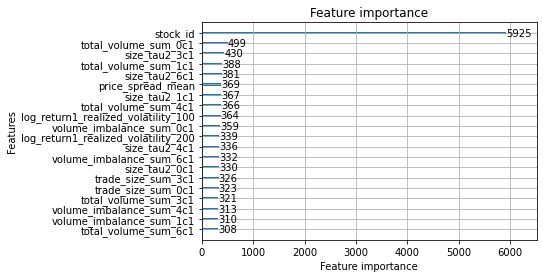

In [16]:
from sklearn.model_selection import KFold
import lightgbm as lgb

seed0=2021
params0 = {
    'objective': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': -1,
    'max_bin':100,
    'min_data_in_leaf':500,
    'learning_rate': 0.05,
    'subsample': 0.72,
    'subsample_freq': 4,
    'feature_fraction': 0.5,
    'lambda_l1': 0.5,
    'lambda_l2': 1.0,
    'categorical_column':[0],
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'n_jobs':-1,
    'verbose': -1}
seed1=42
params1 = {
        'learning_rate': 0.1,        
        'lambda_l1': 2,
        'lambda_l2': 7,
        'num_leaves': 800,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 42,
        'min_data_in_leaf': 700,
        'max_depth': 4,
        'categorical_column':[0],
        'seed': seed1,
        'feature_fraction_seed': seed1,
        'bagging_seed': seed1,
        'drop_seed': seed1,
        'data_random_seed': seed1,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs':-1,
    }
# Function to early stop with root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

def train_and_evaluate_lgb(train, test, params):
    # Hyperparammeters (just basic)
    
    features = [col for col in train.columns if col not in {"time_id", "target", "row_id"}]
    # Create out of folds array
    y = train['target']
    oof_predictions = np.zeros(train.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(test.shape[0])
    # Create a KFold object
    kfold = KFold(n_splits = 5, random_state = 2021, shuffle = True)
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train[features], y_train, weight = train_weights)
        val_dataset = lgb.Dataset(x_val[features], y_val, weight = val_weights)
        model = lgb.train(params = params,
                          num_boost_round=1300,
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          verbose_eval = 250,
                          early_stopping_rounds=50,
                          feval = feval_rmspe)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val[features])
        # Predict the test set
        test_predictions += model.predict(test[features]) / 5
    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    lgb.plot_importance(model,max_num_features=20)
    # Return test predictions
    return test_predictions
# Traing and evaluate
predictions_lgb_1= train_and_evaluate_lgb(train, test,params0)
# predictions_lgb_2= train_and_evaluate_lgb(train, test,params1)
# test['target'] = predictions_lgb_1
# test[['row_id', 'target']].to_csv('submission.csv',index = False)

In [17]:
train.shape[1]

280

In [18]:

from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow import keras
import numpy as np
from keras import backend as K
def root_mean_squared_per_error(y_true, y_pred):
         return K.sqrt(K.mean(K.square( (y_true - y_pred)/ y_true )))
    
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, verbose=0,
    mode='min',restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.195, patience=7, verbose=0,
    mode='min')


In [19]:
# kfold based on the knn++ algorithm

out_train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
out_train = out_train.pivot(index='time_id', columns='stock_id', values='target')

#out_train[out_train.isna().any(axis=1)]
out_train = out_train.fillna(out_train.mean())
out_train.head()

# code to add the just the read data after first execution

# data separation based on knn ++
nfolds = 5 # number of folds
index = []
totDist = []
values = []
# generates a matriz with the values of 
mat = out_train.values

scaler = MinMaxScaler(feature_range=(-1, 1))
mat = scaler.fit_transform(mat)

nind = int(mat.shape[0]/nfolds) # number of individuals

# adds index in the last column
mat = np.c_[mat,np.arange(mat.shape[0])]


lineNumber = np.random.choice(np.array(mat.shape[0]), size=nfolds, replace=False)

lineNumber = np.sort(lineNumber)[::-1]

for n in range(nfolds):
    totDist.append(np.zeros(mat.shape[0]-nfolds))

# saves index
for n in range(nfolds):
    
    values.append([lineNumber[n]])    


s=[]
for n in range(nfolds):
    s.append(mat[lineNumber[n],:])
    
    mat = np.delete(mat, obj=lineNumber[n], axis=0)

for n in range(nind-1):    

    luck = np.random.uniform(0,1,nfolds)
    
    for cycle in range(nfolds):
         # saves the values of index           

        s[cycle] = np.matlib.repmat(s[cycle], mat.shape[0], 1)

        sumDist = np.sum( (mat[:,:-1] - s[cycle][:,:-1])**2 , axis=1)   
        totDist[cycle] += sumDist        
                
        # probabilities
        f = totDist[cycle]/np.sum(totDist[cycle]) # normalizing the totdist
        j = 0
        kn = 0
        for val in f:
            j += val        
            if (j > luck[cycle]): # the column was selected
                break
            kn +=1
        lineNumber[cycle] = kn
        
        # delete line of the value added    
        for n_iter in range(nfolds):
            
            totDist[n_iter] = np.delete(totDist[n_iter],obj=lineNumber[cycle], axis=0)
            j= 0
        
        s[cycle] = mat[lineNumber[cycle],:]
        values[cycle].append(int(mat[lineNumber[cycle],-1]))
        mat = np.delete(mat, obj=lineNumber[cycle], axis=0)


for n_mod in range(nfolds):
    values[n_mod] = out_train.index[values[n_mod]]

In [20]:
#colNames.remove('row_id')
train.replace([np.inf, -np.inf], np.nan,inplace=True)
test.replace([np.inf, -np.inf], np.nan,inplace=True)
qt_train = []
train_nn=train[colNames].copy()
test_nn=test[colNames].copy()
for col in colNames:
    #print(col)
    qt = QuantileTransformer(random_state=21,n_quantiles=2000, output_distribution='normal')
    train_nn[col] = qt.fit_transform(train_nn[[col]])
    test_nn[col] = qt.transform(test_nn[[col]])    
    qt_train.append(qt)


In [21]:
train_nn[['stock_id','time_id','target']]=train[['stock_id','time_id','target']]
test_nn[['stock_id','time_id']]=test[['stock_id','time_id']]

In [22]:
# making agg features
from sklearn.cluster import KMeans
train_p = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
train_p = train_p.pivot(index='time_id', columns='stock_id', values='target')

corr = train_p.corr()

ids = corr.index

kmeans = KMeans(n_clusters=7, random_state=0).fit(corr.values)
print(kmeans.labels_)

l = []
for n in range(7):
    l.append ( [ (x-1) for x in ( (ids+1)*(kmeans.labels_ == n)) if x > 0] )
    

mat = []
matTest = []

n = 0
for ind in l:
    print(ind)
    newDf = train_nn.loc[train_nn['stock_id'].isin(ind) ]
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    mat.append ( newDf )
    
    newDf = test_nn.loc[test_nn['stock_id'].isin(ind) ]    
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    matTest.append ( newDf )
    
    n+=1
    
mat1 = pd.concat(mat).reset_index()
mat1.drop(columns=['target'],inplace=True)

mat2 = pd.concat(matTest).reset_index()
mat2 = pd.concat([mat2,mat1.loc[mat1.time_id==5]])

[1 0 4 2 1 1 2 4 6 2 1 0 4 4 1 1 1 2 4 4 4 0 1 1 3 1 1 4 3 4 3 4 4 1 3 3 4
 3 4 1 4 1 4 4 1 0 4 4 1 0 0 3 3 3 2 0 2 4 1 4 4 1 4 1 0 3 3 0 3 0 6 5 3 3
 0 1 2 0 3 3 3 4 1 1 0 2 3 3 1 0 1 4 4 4 4 4 1 3 1 0 1 4 1 0 1 4 1 0 4 0 4
 0]
[1, 11, 22, 50, 55, 56, 62, 73, 76, 78, 84, 87, 96, 101, 112, 116, 122, 124, 126]
[0, 4, 5, 10, 15, 16, 17, 23, 26, 28, 29, 36, 42, 44, 48, 53, 66, 69, 72, 85, 94, 95, 100, 102, 109, 111, 113, 115, 118, 120]
[3, 6, 9, 18, 61, 63, 86, 97]
[27, 31, 33, 37, 38, 40, 58, 59, 60, 74, 75, 77, 82, 83, 88, 89, 90, 98, 99, 110]
[2, 7, 13, 14, 19, 20, 21, 30, 32, 34, 35, 39, 41, 43, 46, 47, 51, 52, 64, 67, 68, 70, 93, 103, 104, 105, 107, 108, 114, 119, 123, 125]
[81]
[8, 80]


In [23]:
nnn = ['time_id',
     'log_return1_realized_volatility_0c1',
     'log_return1_realized_volatility_1c1',     
     'log_return1_realized_volatility_3c1',
     'log_return1_realized_volatility_4c1',     
     'log_return1_realized_volatility_6c1',
     'total_volume_sum_0c1',
     'total_volume_sum_1c1', 
     'total_volume_sum_3c1',
     'total_volume_sum_4c1', 
     'total_volume_sum_6c1',
     'trade_size_sum_0c1',
     'trade_size_sum_1c1', 
     'trade_size_sum_3c1',
     'trade_size_sum_4c1', 
     'trade_size_sum_6c1',
     'trade_order_count_sum_0c1',
     'trade_order_count_sum_1c1',
     'trade_order_count_sum_3c1',
     'trade_order_count_sum_4c1',
     'trade_order_count_sum_6c1',      
     'price_spread_sum_0c1',
     'price_spread_sum_1c1',
     'price_spread_sum_3c1',
     'price_spread_sum_4c1',
     'price_spread_sum_6c1',   
     'bid_spread_sum_0c1',
     'bid_spread_sum_1c1',
     'bid_spread_sum_3c1',
     'bid_spread_sum_4c1',
     'bid_spread_sum_6c1',       
     'ask_spread_sum_0c1',
     'ask_spread_sum_1c1',
     'ask_spread_sum_3c1',
     'ask_spread_sum_4c1',
     'ask_spread_sum_6c1',   
     'volume_imbalance_sum_0c1',
     'volume_imbalance_sum_1c1',
     'volume_imbalance_sum_3c1',
     'volume_imbalance_sum_4c1',
     'volume_imbalance_sum_6c1',       
     'bid_ask_spread_sum_0c1',
     'bid_ask_spread_sum_1c1',
     'bid_ask_spread_sum_3c1',
     'bid_ask_spread_sum_4c1',
     'bid_ask_spread_sum_6c1',
     'size_tau2_0c1',
     'size_tau2_1c1',
     'size_tau2_3c1',
     'size_tau2_4c1',
     'size_tau2_6c1'] 

In [24]:
mat1 = mat1.pivot(index='time_id', columns='stock_id')
mat1.columns = ["_".join(x) for x in mat1.columns.ravel()]
mat1.reset_index(inplace=True)

mat2 = mat2.pivot(index='time_id', columns='stock_id')
mat2.columns = ["_".join(x) for x in mat2.columns.ravel()]
mat2.reset_index(inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  


In [25]:
import gc
train_nn = pd.merge(train_nn,mat1[nnn],how='left',on='time_id')
test_nn = pd.merge(test_nn,mat2[nnn],how='left',on='time_id')
del mat1,mat2
del train,test
gc.collect()

33

## FFNN

In [26]:
#https://bignerdranch.com/blog/implementing-swish-activation-function-in-keras/
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

hidden_units = (128,64,32)
stock_embedding_size = 24

cat_data = train_nn['stock_id']

def base_model():
    
    # Each instance will consist of two inputs: a single user id, and a single movie id
    stock_id_input = keras.Input(shape=(1,), name='stock_id')
    num_input = keras.Input(shape=(276,), name='num_data')


    #embedding, flatenning and concatenating
    stock_embedded = keras.layers.Embedding(max(cat_data)+1, stock_embedding_size, 
                                           input_length=1, name='stock_embedding')(stock_id_input)
    stock_flattened = keras.layers.Flatten()(stock_embedded)
    out = keras.layers.Concatenate()([stock_flattened, num_input])
    
    # Add one or more hidden layers
    for n_hidden in hidden_units:

        out = keras.layers.Dense(n_hidden, activation='swish')(out)
        

    #out = keras.layers.Concatenate()([out, num_input])

    # A single output: our predicted rating
    out = keras.layers.Dense(1, activation='linear', name='prediction')(out)
    
    model = keras.Model(
    inputs = [stock_id_input, num_input],
    outputs = out,
    )
    
    return model


In [27]:
# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

In [28]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.19, patience=7, verbose=0,
    mode='min')

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, verbose=0,
    mode='min',restore_best_weights=True)

target_name='target'
scores_folds = {}
model_name = 'NN'
pred_name = 'pred_{}'.format(model_name)

n_folds = 5
kf = model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=2020)
scores_folds[model_name] = []
counter = 1

features_to_consider = list(train_nn)

features_to_consider.remove('time_id')
features_to_consider.remove('target')
try:
    features_to_consider.remove('pred_NN')
except:
    pass


train_nn[features_to_consider] = train_nn[features_to_consider].fillna(train_nn[features_to_consider].mean())
test_nn[features_to_consider] = test_nn[features_to_consider].fillna(train_nn[features_to_consider].mean())

train_nn[pred_name] = 0
test_nn[target_name] = 0
test_predictions_nn = np.zeros(test_nn.shape[0])

for n_count in range(n_folds):
    print('CV {}/{}'.format(counter, n_folds))
    
    indexes = np.arange(nfolds).astype(int)    
    indexes = np.delete(indexes,obj=n_count, axis=0) 
    
    indexes = np.r_[values[indexes[0]],values[indexes[1]],values[indexes[2]],values[indexes[3]]]
    
    X_train = train_nn.loc[train_nn.time_id.isin(indexes), features_to_consider]
    y_train = train_nn.loc[train_nn.time_id.isin(indexes), target_name]
    X_test = train_nn.loc[train_nn.time_id.isin(values[n_count]), features_to_consider]
    y_test = train_nn.loc[train_nn.time_id.isin(values[n_count]), target_name]
    
    #############################################################################################
    # NN
    #############################################################################################
    
    model = base_model()
    
    model.compile(
        keras.optimizers.Adam(learning_rate=0.006),
        loss=root_mean_squared_per_error
    )
    
    try:
        features_to_consider.remove('stock_id')
    except:
        pass
    
    num_data = X_train[features_to_consider]
    
    scaler = MinMaxScaler(feature_range=(-1, 1))         
    num_data = scaler.fit_transform(num_data.values)    
    
    cat_data = X_train['stock_id']    
    target =  y_train
    
    num_data_test = X_test[features_to_consider]
    num_data_test = scaler.transform(num_data_test.values)
    cat_data_test = X_test['stock_id']

    model.fit([cat_data, num_data], 
              target,               
              batch_size=2048,
              epochs=1000,
              validation_data=([cat_data_test, num_data_test], y_test),
              callbacks=[es, plateau],
              validation_batch_size=len(y_test),
              shuffle=True,
             verbose = 1)

    preds = model.predict([cat_data_test, num_data_test]).reshape(1,-1)[0]
    
    score = round(rmspe(y_true = y_test, y_pred = preds),5)
    print('Fold {} {}: {}'.format(counter, model_name, score))
    scores_folds[model_name].append(score)
    
    tt =scaler.transform(test_nn[features_to_consider].values)
    #test_nn[target_name] += model.predict([test_nn['stock_id'], tt]).reshape(1,-1)[0].clip(0,1e10)
    test_predictions_nn += model.predict([test_nn['stock_id'], tt]).reshape(1,-1)[0].clip(0,1e10)/n_folds
    #test[target_name] += model.predict([test['stock_id'], test[features_to_consider]]).reshape(1,-1)[0].clip(0,1e10)
       
    counter += 1
    features_to_consider.append('stock_id')

CV 1/5
Epoch 1/1000
168/168 [==============================] - 3s 10ms/step - loss: 22.6877 - val_loss: 1.7882
Epoch 2/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.9153 - val_loss: 0.6510
Epoch 3/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.6791 - val_loss: 0.4982
Epoch 4/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.6063 - val_loss: 0.5735
Epoch 5/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.4864 - val_loss: 0.3252
Epoch 6/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.3658 - val_loss: 2.8641
Epoch 7/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.9092 - val_loss: 0.2422
Epoch 8/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.2809 - val_loss: 0.3179
Epoch 9/1000
168/168 [==============================] - 1s 5ms/step - loss: 0.3134 - val_loss: 0.4352
Epoch 10/1000
168/168 [==============================] - 1s 5ms/step - lo

In [29]:
test_nn["row_id"] = test_nn["stock_id"].astype(str) + "-" + test_nn["time_id"].astype(str) 
#test_nn[target_name] = (test_predictions_nn*0.455+predictions_lgb_1*0.265+preds_tab*0.3)
test_nn[target_name] = (test_predictions_nn*0.4+predictions_lgb_1*0.3+tab_preds*0.3)


score = round(rmspe(y_true = train_nn[target_name].values, y_pred = train_nn[pred_name].values),5)
print('RMSPE {}: {} - Folds: {}'.format(model_name, score, scores_folds[model_name]))

display(test_nn[['row_id', target_name]].head(3))
test_nn[['row_id', target_name]].to_csv('submission.csv',index = False)

RMSPE NN: 1.0 - Folds: [0.20795, 0.21307, 0.20941, 0.21501, 0.21266]


,row_id,target
0,0-4,NaN
1,0-32,NaN
2,0-34,NaN


It's a fork from https://www.kaggle.com/alexioslyon/lgbm-baseline and other great kaggles.thanks a lot!

In [30]:
# total time is around 2:30